In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
import os
import pickle
sys.path.append("../vff")

from run_1d import main 
import torch

import itertools as it
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

# Get training data

## Runing Ising with double space to generate data for different L

We want to create a data set $\mathcal{D}\{x_i, \boldsymbol{y}_i\}$ where $x_i$ are the system sizes $L$ and times $t$ and $\boldsymbol{y}_i$ are the weights of the two layers. We fix the parameters of the Hamiltonian and time.

In [10]:
t_list = [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7]

In [11]:
config = {
    # MODEL
    'L': 8,
    'hamiltonian': 'ising',
    't': 0.5,
    # TEBD
    'test_size': 100,  # number of states in test ensemble
    'tebd_test_steps': 20,  # number of steps in TEBD
    'max_bond': None,  # maximum bond dimension in tebd
    'tebd_cutoff': 1e-10,  # maximum bond dimension in tebd
    # 'ctg': True,
    # TRAINING
    'circuit_name': 'brickwall',
    'circuit_translation': True,  # translation invariant circuit
    'num_steps': 1000,  # maximum number of optimization steps
    'num_samples': 8,  # number of training samples
    'training_states': 'product',
    # STRATEGY`
    'training_strategy': 'multiple_times',
    # HOTSTART
    'depth': 2,  # maximum circuit depth
    'times': t_list,  # increase depth per step
    # OPTIMIZATION
    'learning_rate': 0.001,
    'learning_rate_schedule': lambda opt: torch.optim.lr_scheduler.StepLR(opt, step_size=200, gamma=0.5),
    # META
    'TRAIN': True,
    'TEST': True,
    'TEST_UNITARY': False,
    'PLOT': False,
    'SHOW': False,
    'SEED': 0
}

In [12]:
for L in [8, ]:
    config['L'] = L
    main(config)

Model ising of size 8 at time 0.500

TEBD steps: 10
TEBD max bond dimension: None
TEBD cutoff: 1e-10

(multiple_times) Depth = 2
(multiple_times) Times = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

Circuit: brickwall
Translation: True
Type of training state: product
Number of steps: 1000
Number of samples: 8
Training strategy: multiple_times

Training for t=0.100
Restored train dataset from file
TEBD error: 3.973141880357066e-09
DEPTH = 2
Data for depth 2 exists, loss = 0.00036430961785371974
Test loss for 100 samples = 0.0005815195195942868
Training for t=0.200
Restored train dataset from file
TEBD error: 1.2714054017142611e-07
DEPTH = 2
Data for depth 2 exists, loss = 0.010646802072043493
Test loss for 100 samples = 0.014480050073561679
Training for t=0.300
Restored train dataset from file
TEBD error: 9.654734769267665e-07
DEPTH = 2
Data for depth 2 exists, loss = 0.023732610029372436
Test loss for 100 samples = 0.032294753191312586
Training for t=0.400
Restored train dataset from file
TEBD

# Creating dataset

In [13]:
config_path = config.copy()
config_path['GET_PATH'] = True
config_path['PRINT'] = False
config_path['L'] = 8

depth = config['depth']
data_x = []
data_y = []
infidelities = []
for t in t_list:
    save_path = main(config_path)
    save_path_L = f"{save_path}/t_{t:1.3f}/depth_{depth}/ckpts/parameters.ckpt"
    fid = np.load(f"{save_path}/t_{t:1.3f}/depth_{depth}/test_loss_100.npy")
    infidelities.append(fid)
    # Input data x is the system size and time
    data_x.append(t)
    # Output are flattened parameters
    # Load parameters and flatten them
    parameters = torch.load(save_path_L)
    parameters_flattened = []
    for k in parameters.keys():
        U = parameters[k].reshape(4,4)
        pflat = np.array(parameters[k]).flatten()
        parameters_flattened.append(np.concatenate([pflat.real, pflat.imag]))
    data_y.append(np.stack(parameters_flattened))

## Let's look at the data

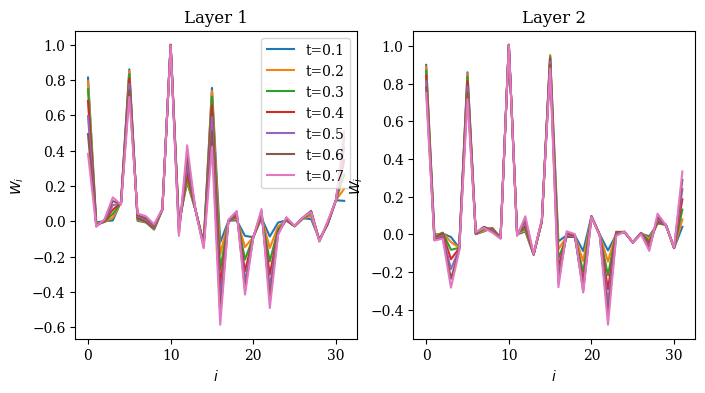

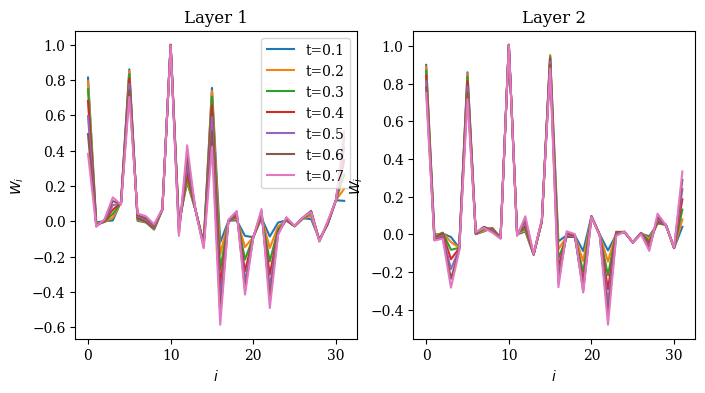

In [14]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(8,4)
for x,y in zip(data_x, data_y):
    axs[0].plot(y[0], label=f't={x}')
    axs[0].set_title('Layer 1')
    axs[1].plot(y[1], label=f't={x}')
    axs[1].set_title('Layer 2')
for ax in axs:
    ax.set_xlabel('$i$')
    ax.set_ylabel('$W_i$')
axs[0].legend()
plt.show()

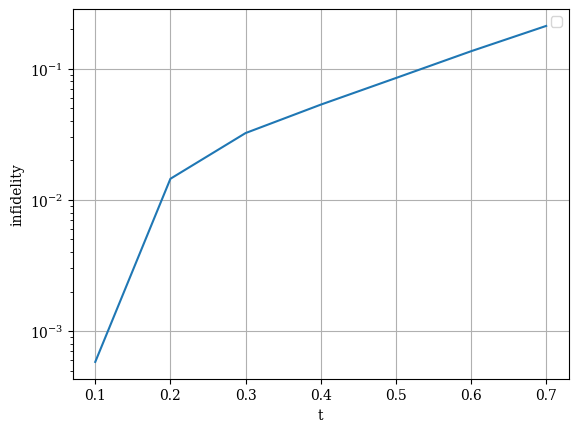

In [15]:
plt.plot(t_list, infidelities)
plt.xlabel('t')
plt.ylabel('infidelity')
plt.yscale('log')
# plt.ylim(1e-3, 1)
plt.grid()
plt.legend()
plt.savefig("infidelity.png")
plt.show()

Weights seem to converge to brown line and is in domain [-1,1]... Should be easy to learn. Let's split the training data in $L_{train}=4,8,16,32$ and $L_{test}= 64,128,$

In [14]:
from torch.utils.data import Dataset

In [16]:
def train_test_split(x, y):
    """Train data is L<=32 and t<=0.3"""
    x_train, x_test = [], []
    y_train, y_test = [], []
    for x_i, y_i in zip(x,y):
        if x_i<=0.5:
            x_train.append(x_i)
            y_train.append(y_i)
        else:
            x_test.append(x_i)
            y_test.append(y_i)
    return x_train, x_test, y_train, y_test
    

In [17]:
data_y = [d.flatten() for d in data_y]
print(data_x)
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(data_x, data_y)
print(f"Train inputs: L = {data_x_train}")
print(f"Test inputs: L = {data_x_test}")
output_size = data_y_train[0].shape[0]
print(f"Output_size: {output_size}")
train_set_size = len(data_y_train)
test_set_size = len(data_y_test)
print(f"Data set size (train): {train_set_size}")
print(f"Data set size (test): {test_set_size}")
print(data_y_train[0].shape)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
Train inputs: L = [0.1, 0.2, 0.3, 0.4, 0.5]
Test inputs: L = [0.6, 0.7]
Output_size: 64
Data set size (train): 5
Data set size (test): 2
(64,)


# Creating a simple Neural Network

In [18]:
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset

import tqdm

In [19]:
class Net(nn.Module):
    def __init__(self, output_size):
      super(Net, self).__init__()
      self.dense_1 = nn.Linear(1, 16)
      self.dense_2 = nn.Linear(16, 100)
      self.dense_3 = nn.Linear(100, 16)
      self.dense_out = nn.Linear(16, output_size)
    # x represents our data
    def forward(self, x):
        # Pass data through conv1
      x = self.dense_1(x)
      x = F.tanh(x)

      x = self.dense_2(x)
      x = F.relu(x)

      x = self.dense_3(x)
      x = F.tanh(x)
        
      x = self.dense_out(x)
      output = 2*F.tanh(x)

      return output

In [20]:
model = Net(output_size)
test_output = model(torch.tensor(data_x_train, dtype=torch.float32)[:,None])
print(f"Output: {test_output[0]}")

Output: tensor([ 0.3691, -0.5986, -0.3178, -0.4006, -0.0039,  0.5356,  0.2125, -0.1385,
         0.2104,  0.2159,  0.3167, -0.4773,  0.0857, -0.4345, -0.6232, -0.1070,
         0.0368, -0.5043, -0.1319,  0.0208, -0.2174,  0.0630,  0.4372, -0.0462,
        -0.4121, -0.3239, -0.4275, -0.2479, -0.2830, -0.2111,  0.3848,  0.2299,
         0.4937,  0.6046, -0.3522, -0.3435,  0.0373, -0.5797,  0.2932, -0.2940,
        -0.5924, -0.5391, -0.3839,  0.0074,  0.2622,  0.3612, -0.0655, -0.1980,
        -0.2225, -0.2322, -0.0897, -0.5166,  0.0284, -0.5169, -0.0886,  0.5110,
        -0.1837,  0.1414,  0.3237,  0.5361,  0.3004, -0.4651,  0.1089, -0.1302],
       grad_fn=<SelectBackward0>)


## Creating a Dataset instance in Torch

In [21]:
class MPSWeightDataset(Dataset):
    def __init__(self, x, y):
        self.data = torch.tensor(x, dtype=torch.float32)[:,None]
        self.labels = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

We're performing online learning, so there are no separate batches. For larger data sets, we may want to set the batch size to 64 to train the model in steps.

In [22]:
train_dataloader = DataLoader(MPSWeightDataset(data_x_train, data_y_train), batch_size=train_set_size)
test_dataloader = DataLoader(MPSWeightDataset(data_x_test, data_y_test), batch_size=test_set_size)

## Create training and test loop

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    loss_tot = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_tot += loss.item()
    return loss_tot


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    return  test_loss / size


An epoch in Machine learning is one step where the model has seen all the data. We use an MSE combined with Adam to find the correct weights.

In [24]:
epochs = 5000
learning_rate = 1e-3
losses = []
val_losses = []
loss_fn = nn.MSELoss()
model = Net(output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

test_loss = test_loop(test_dataloader, model, loss_fn)
print(f"Test loss before train: {test_loss}!")
pbar = tqdm.tqdm(range(epochs), bar_format="\t{l_bar}{bar:25}{r_bar}{bar:-25b}")
for step in pbar:
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    schedule.step()
    pbar.set_description(f"Train loss={loss}")
    losses.append(loss)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    val_losses.append(test_loss)
print(f"Test loss after train: {test_loss}!")

Test loss before train: 0.13397261500358582!


	Train loss=9.968223821488209e-06: 100%|█████████████████████████| 5000/5000 [00:05<00:00, 936.28it/s]                                                                


Test loss after train: 0.00022527950932271779!


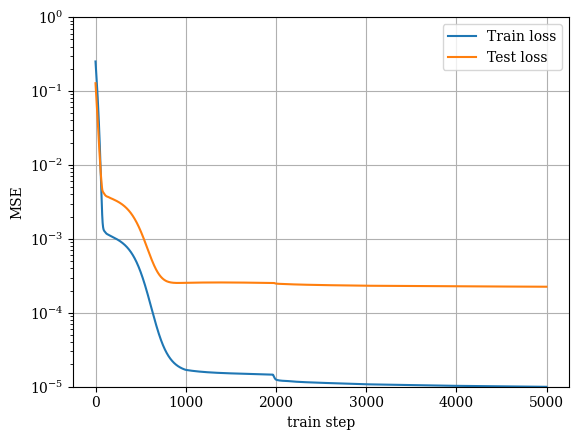

In [25]:
plt.plot(np.abs(losses), label='Train loss')
plt.plot(np.abs(val_losses), label='Test loss')
plt.xlabel('train step')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.ylim([1e-5, 1])
plt.grid()
plt.savefig("loss.png")

We see that we can quickly train the model to predict the correct weights for $L_{train}=4,8,16,32$. The test loss indicates that we can then produce the weights for $L_{test}= 64,128,$ with very high accuracy, even though they were never seen in the training data. The test loss is higher because we overfit on the test data.

# Predicting new weights for L=256

In [26]:
from tn.mps_circuit import TNModel, qmps_brick, qmps_brick_quasi_1d, create_targets, load_gates
from tn.data_states import random_product_state, \
    random_mps_state, get_make_data_set_fn, random_U1_state
from tn.tebd import ising_hamiltonian_quimb, \
    longitudinal_ising_hamiltonian_quimb, \
    heisenberg_hamiltonian_quimb, \
    mbl_hamiltonian_quimb
from tn.trotter import trotter_evolution_optimized_nn_ising_tn

We can now use the model to predict weights for other system sizes:

In [27]:
new_t = 0.7
L = 8
new_L_weights= model(torch.tensor([new_t,], dtype=torch.float32)[None,:])
new_L_weights_split = np.split(new_L_weights.detach().numpy().flatten(), config['depth']*2)
predicted_parameters = []
for i in range(0, config['depth']*2,2):
    predicted_parameters.append(torch.tensor(new_L_weights_split[i].reshape([2]*4)+1j*new_L_weights_split[i+1].reshape([2]*4)))

In [28]:
SEED = config['SEED']
hamiltonian = config['hamiltonian']
t = new_t
depth = config['depth']
num_samples = 20
circuit_translation =  config['circuit_translation']

g = config.get('g', 1.0)
tebd_cutoff = config.get('tebd_cutoff', -1)  # What is the SVD cutoff for TEBD
tebd_max_bond = config.get('max_bond', 20)  # What is the bond dimension cutoff for TEBD
tebd_opts = {'cutoff': tebd_cutoff, 'max_bond': tebd_max_bond}

tebd_granularity =  int(np.round(t / 0.05))
H = lambda x: ising_hamiltonian_quimb(x, 1.0, g)
get_training_state = lambda x, s: random_product_state(x, s)

make_data_set = get_make_data_set_fn(hamiltonian, H(L), tebd_granularity, tebd_opts, False)
psi0_list_train, psit_list_train, tebd_errors = make_data_set(lambda x: get_training_state(L, x),
                                                              t,
                                                              num_samples, SEED)
psi_pqc = qmps_brick(L, in_depth=depth, rand=False, val_iden=0.01)
psi, psi_tars = create_targets(L, psi_pqc, psi0_list_train, psit_list_train, device='cpu')
mps_model = TNModel(psi, psi_tars, translation=circuit_translation)

In [29]:
print("Inidelity before:", mps_model())
par_names = [f"torch_params.{i}" for i in range(config['depth'])]
param_dict = dict(zip(par_names, predicted_parameters))
mps_model.load_state_dict(param_dict, strict=True)
mps_model.eval()
predicted_infidelity = mps_model()
print("Infidelity with predicted weights:", mps_model())

Inidelity before: tensor(0.9950, dtype=torch.float64, grad_fn=<RsubBackward1>)
Infidelity with predicted weights: tensor(0.2503, dtype=torch.float64, grad_fn=<RsubBackward1>)


We get a reasonable infidelity for 

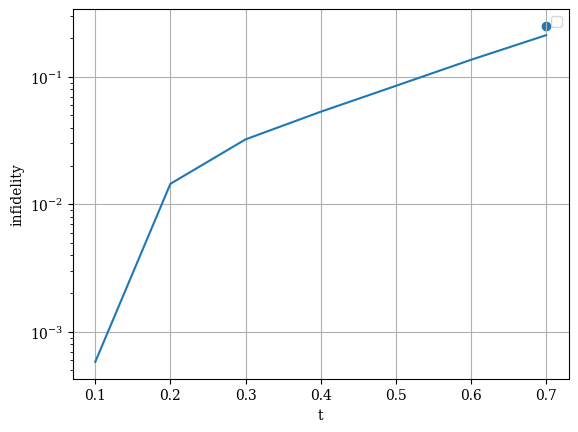

In [30]:
plt.plot(t_list, infidelities)
plt.scatter(new_t, predicted_infidelity.detach().numpy())
plt.xlabel('t')
plt.ylabel('infidelity')
plt.yscale('log')
# plt.ylim(1e-3, 1)
plt.grid()
plt.legend()
plt.savefig("infidelity.png")
plt.show()

Seems like a reasonable fidelity!